In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
# Modeling
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from ecallisto_dataset import (
    preprocess_spectrogram,
    EcallistoDatasetBinary,
    CustomSpecAugment,
    custom_resize,
    TimeWarpAugmenter
)

import pandas as pd

print(f'PyTorch version {torch.__version__}')
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("GPU is not available.")
    device = 'cpu'

/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.3.0+cu121
GPU is not available.


In [5]:
ds = load_dataset('i4ds/radio-sunburst-ecallisto-paths-df')

Generating test split: 100%|██████████| 30549/30549 [00:00<00:00, 1613242.59 examples/s]


In [ ]:
ds_burst = ds['test'].filter(lambda x: x['label'])

In [ ]:
ds_burst

Dataset({
    features: ['file_path', 'label', 'antenna', 'datetime'],
    num_rows: 2862
})

In [ ]:
15 * 60 * 4

3600

In [12]:
# Transforms
resize_func = Compose(
    [
        lambda x: custom_resize(x, (224, 224)),  # Resize the image
    ]
)
augm_before_resize = TimeWarpAugmenter(500)
augm_after_resize = CustomSpecAugment(
    frequency_masking_para=56,
    method='random',
)

In [13]:
# Transforms

# Data Loader
ds_test = EcallistoDatasetBinary(
    ds['test'],
    resize_func=resize_func,
    augm_before_resize=augm_before_resize,
    augm_after_resize=augm_after_resize,
    normalization_transform=preprocess_spectrogram,
)


test_dataloader = DataLoader(
    ds_test,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    persistent_workers=False,
)


In [14]:
IDX = 1

In [ ]:
with torch.no_grad():
    for example in test_dataloader:
        example = example

#plt.imshow(example[0][IDX].squeeze(), aspect='auto')

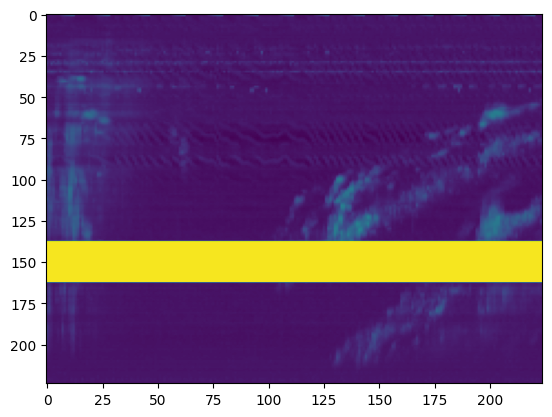

In [98]:
with torch.no_grad():
    for example in test_dataloader:
        example = example
        break

plt.imshow(example[0][IDX].squeeze(), aspect='auto')

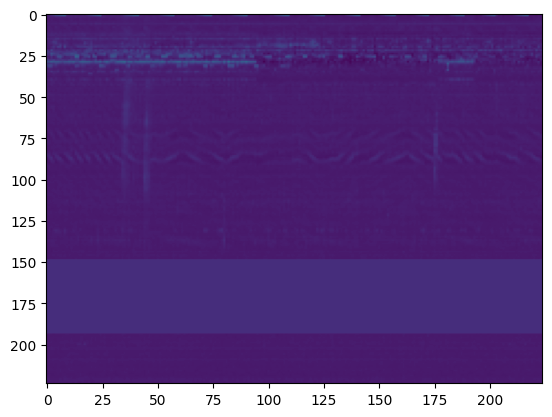

In [91]:
df = pd.read_parquet(ds_burst[IDX]['file_path'])
plt.imshow(df.T, aspect='auto')

In [85]:
example[0][IDX].squeeze()

tensor([[0.1866, 0.2118, 0.3167,  ..., 0.1866, 0.1866, 0.1860],
        [0.2026, 0.2145, 0.2333,  ..., 0.1807, 0.1961, 0.1856],
        [0.1943, 0.1988, 0.2016,  ..., 0.1873, 0.1998, 0.1864],
        ...,
        [0.1972, 0.1945, 0.1906,  ..., 0.1965, 0.2001, 0.2033],
        [0.1925, 0.1972, 0.1935,  ..., 0.1925, 0.1988, 0.1988],
        [0.1940, 0.1937, 0.1935,  ..., 0.1922, 0.1940, 0.1940]])

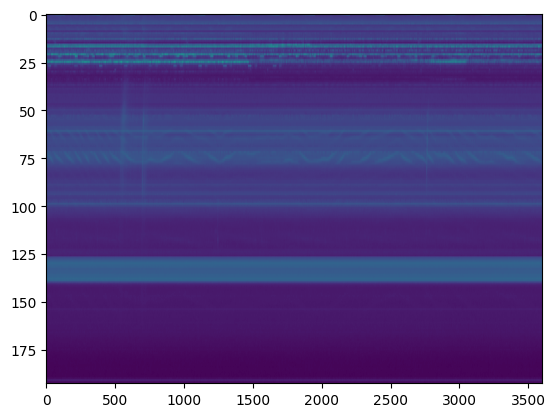

In [84]:
df = pd.read_parquet(ds_burst[IDX]['file_path'])
plt.imshow(df.T, aspect='auto')

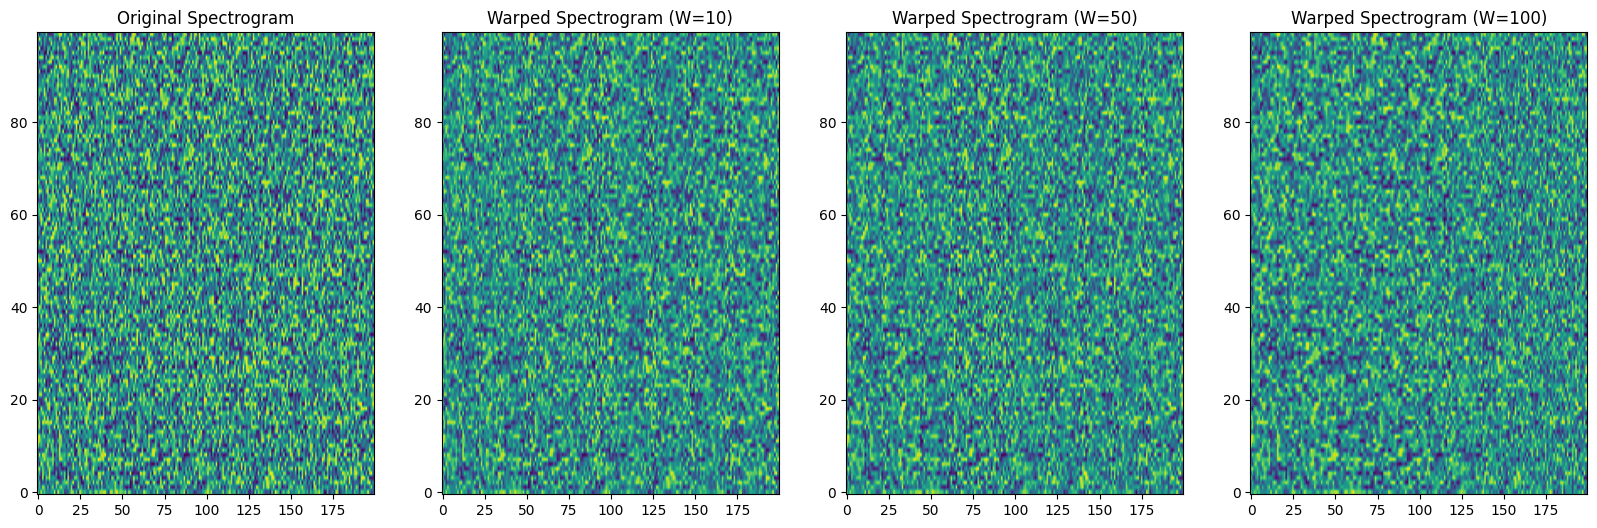

In [38]:
import torch
import matplotlib.pyplot as plt

# Define the time warp augmenter with different W values
augmenter_w10 = TimeWarpAugmenter(W=10)
augmenter_w50 = TimeWarpAugmenter(W=15)
augmenter_w100 = TimeWarpAugmenter(W=50)

# Generate a random spectrogram
spectrogram = torch.rand(1, 100, 200)

# Apply time warp with different W values
warped_spectrogram_w10 = augmenter_w10(spectrogram)
warped_spectrogram_w50 = augmenter_w50(spectrogram)
warped_spectrogram_w100 = augmenter_w100(spectrogram)

# Display the original and warped spectrograms
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax[0].imshow(spectrogram.squeeze(0).numpy(), aspect='auto', origin='lower')
ax[0].set_title("Original Spectrogram")
ax[1].imshow(warped_spectrogram_w10.squeeze(0).numpy(), aspect='auto', origin='lower')
ax[1].set_title("Warped Spectrogram (W=10)")
ax[2].imshow(warped_spectrogram_w50.squeeze(0).numpy(), aspect='auto', origin='lower')
ax[2].set_title("Warped Spectrogram (W=50)")
ax[3].imshow(warped_spectrogram_w100.squeeze(0).numpy(), aspect='auto', origin='lower')
ax[3].set_title("Warped Spectrogram (W=100)")
plt.show()
